In [2]:
from datasets import load_dataset
import pandas as pd

# Load the dataset 
ds = load_dataset("UniqueData/customers-reviews-on-banks")

# Convert Hugging Face dataset to pandas DataFrame
df = pd.DataFrame(ds["train"])

print(df.shape)
df.head()

(19271, 7)


,author,date,location,bank,star,text,like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,NaN
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,NaN
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0


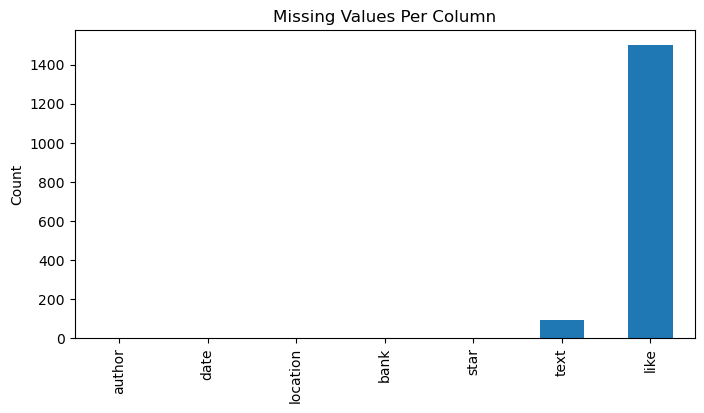

In [3]:
#-------Data Quality Assessment----------

# Load pyplot module from Matplotlib 
import matplotlib.pyplot as plt 

# Identify missing values 
df.isnull().sum().plot(kind="bar", figsize=(8,4))
plt.title("Missing Values Per Column")
plt.ylabel("Count")
plt.show()

In [4]:
# check the percentage of missing reviews in the text column
missing_count = df['text'].isnull().sum()
total_count = len(df)

print(f"Missing review_text: {missing_count}")
print(f"Total rows: {total_count}")
print(f"Percentage missing: {missing_count/total_count*100:.2f}%")

Missing review_text: 90
Total rows: 19271
Percentage missing: 0.47%


In [5]:
# check the number of rows after dropping missing rows
df = df.dropna(subset=['text']).reset_index(drop=True)
print("After removing missing text rows:", len(df))

After removing missing text rows: 19181


In [6]:
# check for duplicates 
duplicate_count = df.duplicated().sum()
total_rows = len(df)

print(f"Total duplicate rows: {duplicate_count}")
print(f"Percentage of duplicates: {duplicate_count/total_rows*100:.2f}%")

Total duplicate rows: 0
Percentage of duplicates: 0.00%


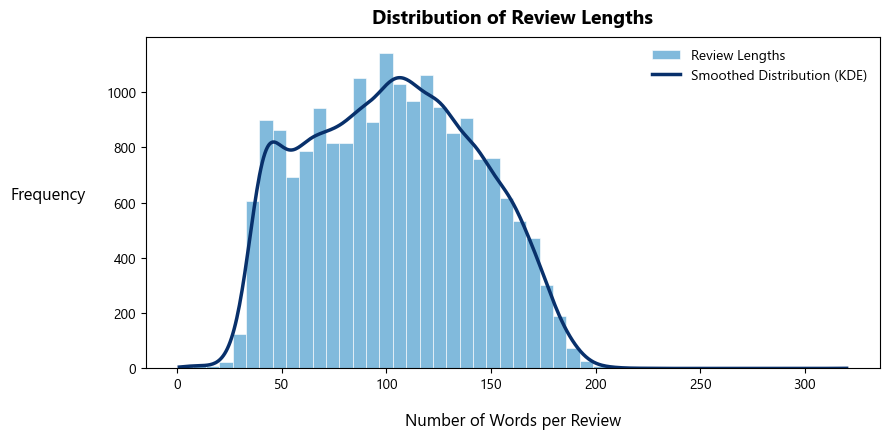

In [7]:
import numpy as np 
from scipy.stats import gaussian_kde

# --- Data ---
df['text_length'] = df['text'].astype(str).str.split().str.len()
x = df['text_length']

# --- KDE (smooth curve) ---
kde = gaussian_kde(x)
x_vals = np.linspace(x.min(), x.max(), 500)
kde_vals = kde(x_vals)

# --- Styling ---
plt.figure(figsize=(9, 4.5))
plt.rcParams.update({
    'font.family': 'Segoe UI', 
    'axes.titlesize': 14, 
    'axes.labelsize': 12, 
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Elegant, coordinated colour palette
bar_color = '#6BAED6' 
line_color = '#08306B'
bg_color = '#F9F9F9'

# --- Histogram (frequency) ---
plt.hist(
    x, 
    bins= 50,
    color=bar_color,
    alpha=0.85,
    edgecolor='white', 
    linewidth=0.5,
    label='Review Lengths'
)

# --- KDE Line (scaled to match histogram height visually) ---
scale = len(x) * (x.max() - x.min()) / 50
plt.plot(
    x_vals, 
    kde_vals * scale, 
    color=line_color, 
    linewidth=2.5,
    label='Smoothed Distribution (KDE)'
)

# --- Titles and Labels ---
plt.title("Distribution of Review Lengths", weight='bold', pad=10)
plt.xlabel("Number of Words per Review", labelpad=15)
plt.ylabel("Frequency", rotation=0, labelpad=15, ha='right')

# --- Final touches ---
plt.grid(False)
plt.legend(frameon=False, fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

In [8]:
# Summary statistics for text length 
summary = df['text_length'].agg([
    'count', 'mean', 'std', 'min', 'median', 'max', 'skew', 'kurt'
])

print(summary)

count     19181.000000
mean        102.784943
std          39.858633
min           1.000000
median      103.000000
max         320.000000
skew          0.081792
kurt         -0.869640
Name: text_length, dtype: float64


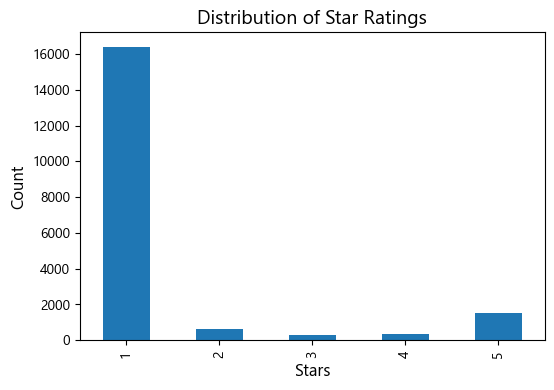

In [9]:
# Check for class imbalance for star rating 
if 'star' in df.columns:
    df['star'].value_counts().sort_index().plot(kind='bar', figsize=(6,4))
    plt.title("Distribution of Star Ratings")
    plt.xlabel("Stars")
    plt.ylabel("Count")

In [10]:
# Quantify class imbalance 
print(df['star'].value_counts(normalize=True)*100)

star
1    85.490850
5     7.804598
2     3.248006
4     1.939419
3     1.517126
Name: proportion, dtype: float64


In [11]:
# Map star ratings to sentiment labels 
def map_sentiment(rating):
    if rating in [1, 2]:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['star'].apply(map_sentiment)

In [12]:
# Print the number of reviews and percentage for each sentiment category 
print(df['sentiment'].value_counts())
df['sentiment'].value_counts(normalize=True) * 100

sentiment
Negative    17021
Positive     1869
Neutral       291
Name: count, dtype: int64


sentiment
Negative    88.738856
Positive     9.744018
Neutral      1.517126
Name: proportion, dtype: float64

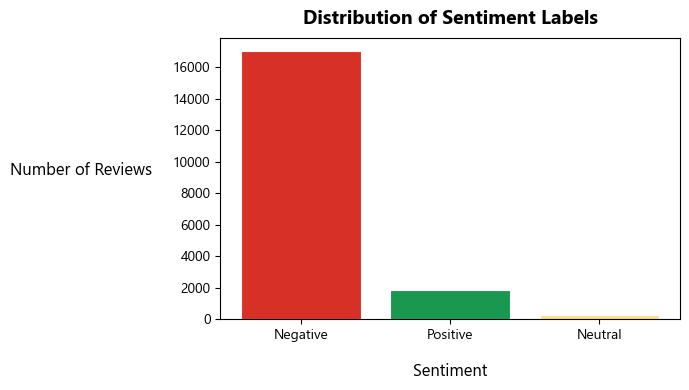

In [13]:
#--- Visualise Sentiment Counts ---

# Get sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Define clean, professional colour palette
colors = { 
    'Negative': '#D73027', 
    'Neutral': '#FEE08B',
    'Positive': '#1A9850'
}

plt.figure(figsize=(7, 4))
plt.rcParams.update({
    'font.family': 'Segoe UI',
    'axes.titlesize': 14,
    'axes.labelsize': 12, 
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# --- Bar Plot ---
plt.bar(
    sentiment_counts.index, 
    sentiment_counts.values, 
    color=[colors[label] for label in sentiment_counts.index],
    edgecolor='white', 
    linewidth=0.8
)

# --- Labels and Title ---
plt.title("Distribution of Sentiment Labels", weight='bold', pad=10)
plt.xlabel("Sentiment", labelpad=15)
plt.ylabel("Number of Reviews", rotation=0, labelpad=15, ha='right')

# --- Clean layout ---
plt.grid(False)
plt.tight_layout()
plt.show()

In [14]:
# Sanity check with a pivot table 
print(df.groupby('star')['sentiment'].value_counts())

star  sentiment
1     Negative     16398
2     Negative       623
3     Neutral        291
4     Positive       372
5     Positive      1497
Name: count, dtype: int64


In [15]:
# Blank text check 
blank_reviews = df['text'].astype(str).str.strip().eq('').sum()
print(f"Blank reviews: {blank_reviews}")

Blank reviews: 0


In [16]:
# Average review length per sentiment 
df.groupby('sentiment')['text_length'].mean()

sentiment
Negative    107.683450
Neutral      76.828179
Positive     62.215623
Name: text_length, dtype: float64

In [17]:
# Most frequent words before cleaning 
from collections import Counter 
from itertools import chain 

word_counts = Counter(chain.from_iterable(df['text'].str.lower().str.split()))
print(word_counts.most_common(20))

[('i', 78309), ('the', 70416), ('to', 67212), ('and', 54711), ('a', 47793), ('my', 41497), ('they', 32208), ('was', 24843), ('of', 24144), ('for', 23118), ('have', 20607), ('that', 20582), ('with', 20560), ('in', 20212), ('on', 17397), ('it', 16975), ('is', 16777), ('this', 15678), ('not', 15470), ('me', 14881)]


In [18]:
# Remove stopwords from dataset
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stops = set(stopwords.words('english'))

# Remove stopwords from text column 
df['clean_text'] = (
    df['text']
    .astype(str)
    .str.lower()
    .str.split()
    .apply(lambda words: ' '.join([w for w in words if w not in stops]))
)

print(df[['text', 'clean_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  Very easy to use to view statements and make o...   
1  Merrick Bank has always been good to me for bu...   
2  Times are tough for everyone and I have worked...   
3  I can not asked for a better Credit Card Compa...   
4  Updated on 02/10/2023: I was happy to sign for...   

                                          clean_text  
0  easy use view statements make online payments....  
1  merrick bank always good business. rely merric...  
2  times tough everyone worked hard get credit re...  
3  asked better credit card company, merrick bank...  
4  updated 02/10/2023: happy sign new credit card...  


In [19]:
# Quality check of clean_text 
mean_words = df['clean_text'].apply(lambda x: len(str(x).split())).mean()
median_words = df['clean_text'].apply(lambda x: len(str(x).split())).median()
print(f"Average words per review: {mean_words:.2f}")
print(f"Median words per review: {median_words:.2f}")

# Compute standard deviation 
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
std_value = df['word_count'].std()
print("Standard deviation of word count:", round(std_value, 2))

Average words per review: 52.25
Median words per review: 52.00
Standard deviation of word count: 19.95


In [20]:
# Convert all text to lowercase 
df['clean_text'] = df['clean_text'].astype(str).str.lower()
df['clean_text'].sample(5, random_state=42)

18727    nothing upstanding customer theirs. came acros...
7136     anyone looking merchant account please stay aw...
11621    never use company va home loan. realtor 13 yea...
11887    since comenity took aaa bank america, issues a...
11330    use be. put money wrong account. taken name ch...
Name: clean_text, dtype: object

In [21]:
# Encode labels to numbers 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 

# Features (x) and labels (y)
x = df['clean_text']
y = df['sentiment']

# Encode sentiment labels into numbers 
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create id2label: numeric -> original label 
id2label = {i: label for i, label in enumerate(le.classes_)}

# Map numeric labels to original class names 
label2id = {v: k for k, v in id2label.items()}
print("label2id:", label2id)

label2id: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [22]:
# Split into training and test data 
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

In [23]:
# Handle class imbalance automatically for the logistic regression model
from sklearn.linear_model import LogisticRegression 

lr_model=LogisticRegression(
    max_iter=1000, 
    class_weight='balanced', 
    solver='liblinear' 
)

In [24]:
# Convert text to numerical features (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1,2), 
    stop_words='english'
)

x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [25]:
# Train the lr model 
lr_model.fit(x_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

              precision    recall  f1-score   support

    Negative       0.96      0.99      0.97      3405
     Neutral       0.28      0.09      0.13        58
    Positive       0.86      0.74      0.79       374

    accuracy                           0.95      3837
   macro avg       0.70      0.60      0.63      3837
weighted avg       0.94      0.95      0.94      3837



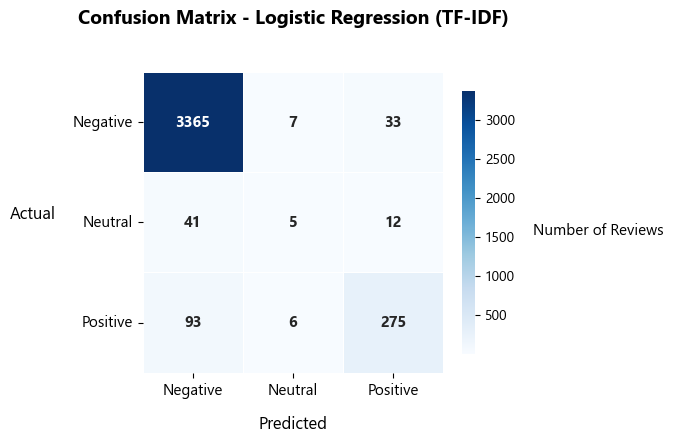

In [26]:
# Evaluate the model's performance 
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt 

y_pred = lr_model.predict(x_test_tfidf)

print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=le.classes_, 
    yticklabels=le.classes_,
    annot_kws={"size": 11, "weight": "bold"}, 
    linewidths=0.7, 
    square=True, 
    cbar_kws={"shrink": 0.8, "label": "Number of Reviews"}
)

# Define title, labels, ticks and cbar 
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)", fontsize=14, weight='bold', pad=35)
plt.xlabel("Predicted", fontsize=12, labelpad =12)
plt.ylabel("Actual", fontsize=12, labelpad=12, rotation=0, ha='right')
plt.xticks(fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Make colourbar label horizontal 
cbar = plt.gcf().axes[-1]
cbar.set_ylabel("Number of Reviews", rotation=0, labelpad=60, fontsize=11)
cbar.yaxis.set_label_position('right')

plt.gca().set_facecolor("#F7F9FB")
plt.tight_layout()
plt.show()

Negative class index: 0


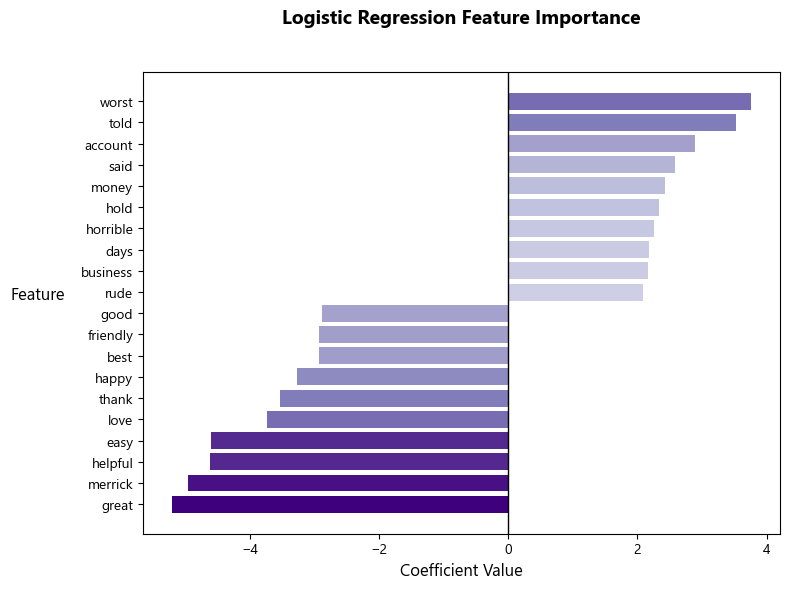

In [27]:
# Feature importance plot 

# Extract feature names 
feature_names = tfidf.get_feature_names_out()

# Extract index of the negative class
neg_class_index = le.transform(['Negative'])[0]
print("Negative class index:", neg_class_index)

# Extract coefficients for the negative class 
coefs = lr_model.coef_[neg_class_index]

# Build the dataframe
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
})

# Top features pushing reviews towards negative sentiment 
top_neg = coef_df.sort_values("coef", ascending=True).head(10)

# Features resisting negative classification (useful contrast)
top_pos = coef_df.sort_values("coef", ascending=False).head(10)

# Combine for chart 
coef_top = pd.concat([top_neg, top_pos]).sort_values("coef")

# Normalise for colour scaling 
values = np.abs(coef_top["coef"].values)
norm = (values - values.min()) / (values.max() - values.min() + 1e-9)

# Clipped purple colour map 
import matplotlib.colors as mcolors 

base_cmap = plt.cm.Purples
clipped_cmap = mcolors.LinearSegmentedColormap.from_list(
    "clipped_purples",
    base_cmap(np.linspace(0.3, 1, 256))
)

colors = clipped_cmap(norm)

plt.figure(figsize=(8, 6))
plt.barh(coef_top["feature"], coef_top["coef"], color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature", fontsize=12, labelpad=12, rotation=0, ha='right')
plt.title("Logistic Regression Feature Importance", fontsize=14, weight='bold', pad=35)
plt.tight_layout()
plt.show()

In [28]:
# Handle class imbalance for XGboost model 
from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state=42)
x_train_bal, y_train_bal = ros.fit_resample(x_train_tfidf, y_train)

In [29]:
from collections import Counter 
print("Before balancing:", Counter(y_train))
print("After balancing:", Counter(y_train_bal))

Before balancing: Counter({np.int64(0): 13616, np.int64(2): 1495, np.int64(1): 233})
After balancing: Counter({np.int64(2): 13616, np.int64(0): 13616, np.int64(1): 13616})


In [30]:
# Define and train model 
from xgboost import XGBClassifier 

xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    subsample=0.8, 
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42, 
    eval_metric='mlogloss'
)

xgb_model.fit(x_train_bal, y_train_bal)

# Predict on test data 
y_pred_xgb = xgb_model.predict(x_test_tfidf)

In [31]:
# Which label IDs are in the test set? 
import numpy as np
labels_present = np.unique(y_test)
print(labels_present)

# Map those IDs to their string names 
safe_target_names = [le.classes_[i] for i in labels_present]

[0 1 2]


In [32]:
# Evaluate performance
print("\nClassification Report - XGBoost (TF-IDF):")
print(classification_report
      (y_test, 
       y_pred_xgb, 
       labels=labels_present,
       target_names=safe_target_names
    ))


Classification Report - XGBoost (TF-IDF):
              precision    recall  f1-score   support

    Negative       0.97      0.89      0.93      3405
     Neutral       0.06      0.29      0.10        58
    Positive       0.64      0.74      0.69       374

    accuracy                           0.87      3837
   macro avg       0.56      0.64      0.57      3837
weighted avg       0.93      0.87      0.90      3837



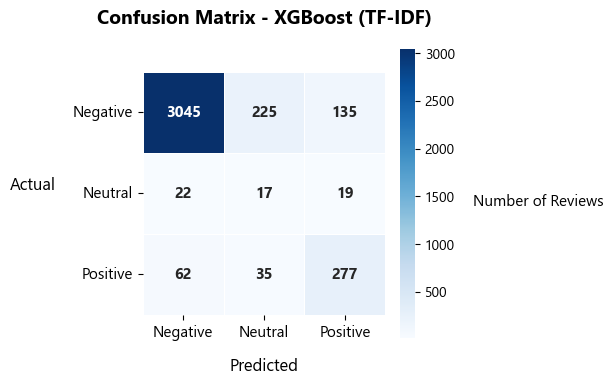

In [35]:
# Confusion Matrix Visualisation 
plt.figure(figsize=(6,5))

# Compute confusion matrix 
cm = confusion_matrix(y_test, y_pred_xgb)

# Heatmap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    annot_kws={"size": 11, "weight": "bold"}, 
    linewidths=0.7, 
    square=True, 
    cbar_kws={"shrink": 0.8, "label": "Number of Reviews"},
    xticklabels=le.classes_, 
    yticklabels=le.classes_
)

# Define title, labels, ticks and cbar 
plt.title("Confusion Matrix - XGBoost (TF-IDF)", fontsize=14, weight='bold', pad=35)
plt.xlabel("Predicted", fontsize=12, labelpad =12)
plt.ylabel("Actual", fontsize=12, labelpad=12, rotation=0, ha='right')
plt.xticks(fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.gca().set_xticklabels(le.classes_)
plt.gca().set_yticklabels(le.classes_)

# Make colourbar label horizontal 
cbar = plt.gcf().axes[-1]
cbar.set_ylabel("Number of Reviews", rotation=0, labelpad=60, fontsize=11)
cbar.yaxis.set_label_position('right')

plt.gca().set_facecolor("#F7F9FB")
plt.tight_layout()
plt.show()

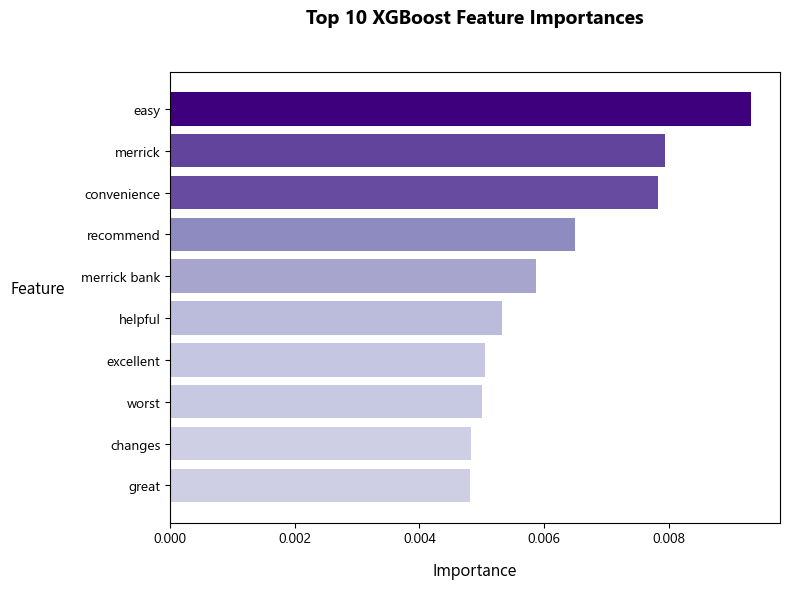

In [34]:
# Extract feature names
feature_names = tfidf.get_feature_names_out()

# Extract importances
importances = xgb_model.feature_importances_

# Build dataframe and get top features
fi_df = pd.DataFrame({
    "feature": feature_names, 
    "importance": importances
})

# Sort by importance
fi_top = fi_df.sort_values("importance", ascending=False).head(10)

# Values for colour gradient 
values = fi_top["importance"].values

# Normalise to 0-1 for the colormap 
norm = (values - values.min()) / (values.max() - values.min() + 1e-9)

# Choose a colormap
import matplotlib.colors as mcolors
cmap = plt.cm.Purples
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "clipped_purples",
    cmap(np.linspace(0.3, 1, 256))
)
colors = new_cmap(norm)

# Plot 
plt.figure(figsize=(8, 6))
plt.barh(fi_top["feature"], fi_top["importance"], color=colors)
plt.xlabel("Importance", fontsize=12, labelpad =12)
plt.ylabel("Feature", fontsize=12, labelpad=12, rotation=0, ha='right')
plt.title("Top 10 XGBoost Feature Importances", fontsize=14, weight='bold', pad=35)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()